<a href="https://colab.research.google.com/github/koyamahr/retro-astro-jax/blob/main/toomre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 0-3: 銀河の架け橋 (Galactic Bridges and Tails)
 Original Paper: Toomre, A., & Toomre, J. (1972).
  "Galactic Bridges and Tails", The Astrophysical Journal, 178, 623-666.
  
  1. はじめに (Introduction)
  
  1970年代以前、M51（子持ち銀河）やアンテナ銀河に見られる「長く伸びた腕」や「奇妙な形」は、銀河磁場によるものか、あるいは特殊な爆発現象によるものだと考えられていました。しかし、Alar Toomre と Juri Toomre の兄弟は、1972年の歴史的な論文で、これらが**「単なる重力（潮汐力）」**によって説明できることを示しました。彼らは、銀河同士がすれ違うとき、重力が星々を引き剥がし、美しい「架け橋 (Bridge)」や「尾 (Tail)」を作ることを、数値計算で証明したのです。この章では、彼らが用いた**「制限三体問題 (Restricted Three-Body Problem)」**の手法をJAXで再現します。
  
  2. 物理モデルとJAX実装 (Physics & JAX)
  
  計算を単純化するため、以下のモデルを採用します：銀河中心: 2つの質点 ($M_1, M_2$) が、互いの重力でケプラー運動（放物線軌道）をする。星: 質量ゼロのテスト粒子。$M_1$ の周りを回っているが、銀河の接近に伴い、$M_1$ と $M_2$ 両方の重力を受けて軌道を変える。
  
  セットアップ

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation

# JAXを64bitモードにして精度を確保（お好みで）
jax.config.update("jax_enable_x64", True)

重力カーネル (The Gravity Kernel)
ここで JAX の vmap (自動ベクトル化) が火を吹きます。数千個の粒子に対する重力計算を、あたかも1つの粒子に対する計算のように記述できます。

In [2]:
@jax.jit
def gravitational_acceleration(positions, M1_pos, M1_mass, M2_pos, M2_mass, softening=0.1):
    """
    全テスト粒子に対する重力加速度を計算
    positions: (N, 3) 粒子の位置
    M1_pos, M2_pos: (3,) 銀河中心の位置
    """
    # 銀河1からの重力
    r1_vec = M1_pos - positions
    r1_sq = jnp.sum(r1_vec**2, axis=1) + softening**2
    acc1 = (M1_mass / jnp.power(r1_sq, 1.5))[:, None] * r1_vec

    # 銀河2からの重力
    r2_vec = M2_pos - positions
    r2_sq = jnp.sum(r2_vec**2, axis=1) + softening**2
    acc2 = (M2_mass / jnp.power(r2_sq, 1.5))[:, None] * r2_vec

    return acc1 + acc2

時間積分 (Time Integration)
銀河中心の動き（解析解）と、粒子の動き（数値積分）を組み合わせます。

In [3]:
def solve_kepler_2body(t, e, a, m1, m2):
    """銀河中心核の軌道を計算 (近点通過 t=0)"""
    # 平均近点離角 M
    n = jnp.sqrt((m1 + m2) / jnp.abs(a)**3)
    M = n * t

    # ケプラー方程式を解く (簡易Newton法)
    E = M
    for _ in range(5):
        E = E - (E - e * jnp.sin(E) - M) / (1 - e * jnp.cos(E))

    # 軌道面座標
    X = a * (jnp.cos(E) - e)
    Y = a * jnp.sqrt(1 - e**2) * jnp.sin(E)

    # 重心座標系へ
    pos1 = jnp.array([-X * m2 / (m1 + m2), -Y * m2 / (m1 + m2), 0.0])
    pos2 = jnp.array([+X * m1 / (m1 + m2), +Y * m1 / (m1 + m2), 0.0])
    return pos1, pos2

@jax.jit
def step_simulation(pos, vel, t, dt, m1, m2, e, a):
    """1ステップの時間発展 (Leapfrog法)"""
    # 現在の銀河位置
    g1_pos, g2_pos = solve_kepler_2body(t, e, a, m1, m2)

    # Kick (v += a * dt/2)
    acc = gravitational_acceleration(pos, g1_pos, m1, g2_pos, m2)
    vel_half = vel + acc * (dt / 2.0)

    # Drift (x += v * dt)
    pos_new = pos + vel_half * dt

    # 次の銀河位置
    g1_pos_next, g2_pos_next = solve_kepler_2body(t + dt, e, a, m1, m2)

    # Kick (v += a * dt/2)
    acc_next = gravitational_acceleration(pos_new, g1_pos_next, m1, g2_pos_next, m2)
    vel_new = vel_half + acc_next * (dt / 2.0)

    return pos_new, vel_new

3. シミュレーション実行 (Simulation)

Toomre論文のモデルに近いパラメータを設定します。

*  離心率 $e = 0.5$ (楕円軌道)
*  質量比 $M_1 = M_2$
*  初期配置: $M_1$ の周りに円盤状に粒子を配置

In [4]:
# --- パラメータ ---
N_particles = 2000
M1, M2 = 1.0, 1.0
eccentricity = 0.5
semimajor = 20.0
dt = 0.05
t_range = jnp.arange(-40, 60, dt)

# --- 初期化 ---
rng = jax.random.PRNGKey(42)
# 銀河1の周りにリング状に粒子を配置 (半径 0.2 ~ 0.5 * 距離)
r = jax.random.uniform(rng, (N_particles,), minval=2.0, maxval=8.0)
theta = jax.random.uniform(rng, (N_particles,), minval=0, maxval=2*jnp.pi)

# 位置と速度 (円運動)
x, y = r * jnp.cos(theta), r * jnp.sin(theta)
z = jnp.zeros_like(r)
pos = jnp.stack([x, y, z], axis=1)

v_circ = jnp.sqrt(M1 / r)
vx, vy = -v_circ * jnp.sin(theta), v_circ * jnp.cos(theta)
vel = jnp.stack([vx, vy, z], axis=1)

# t_start時点の銀河位置までシフト
g1_start, g2_start = solve_kepler_2body(t_range[0], eccentricity, semimajor, M1, M2)
pos += g1_start
vel += jnp.array([0.0, 0.5, 0.0]) # 銀河自体の速度を適当に加算 (簡易)

# --- メインループ ---
history_pos = []
history_g1 = []
history_g2 = []

current_pos, current_vel = pos, vel

print("Simulating 1972 physics...")
for i, t in enumerate(t_range):
    current_pos, current_vel = step_simulation(current_pos, current_vel, t, dt, M1, M2, eccentricity, semimajor)

    # 間引きして保存 (メモリ節約)
    if i % 10 == 0:
        history_pos.append(current_pos)
        g1, g2 = solve_kepler_2body(t, eccentricity, semimajor, M1, M2)
        history_g1.append(g1)
        history_g2.append(g2)

print(f"Done! Frames: {len(history_pos)}")

Simulating 1972 physics...
Done! Frames: 200


4. 結果の可視化 (Visualization)

Toomreの論文にあるような、スナップショットを表示します。

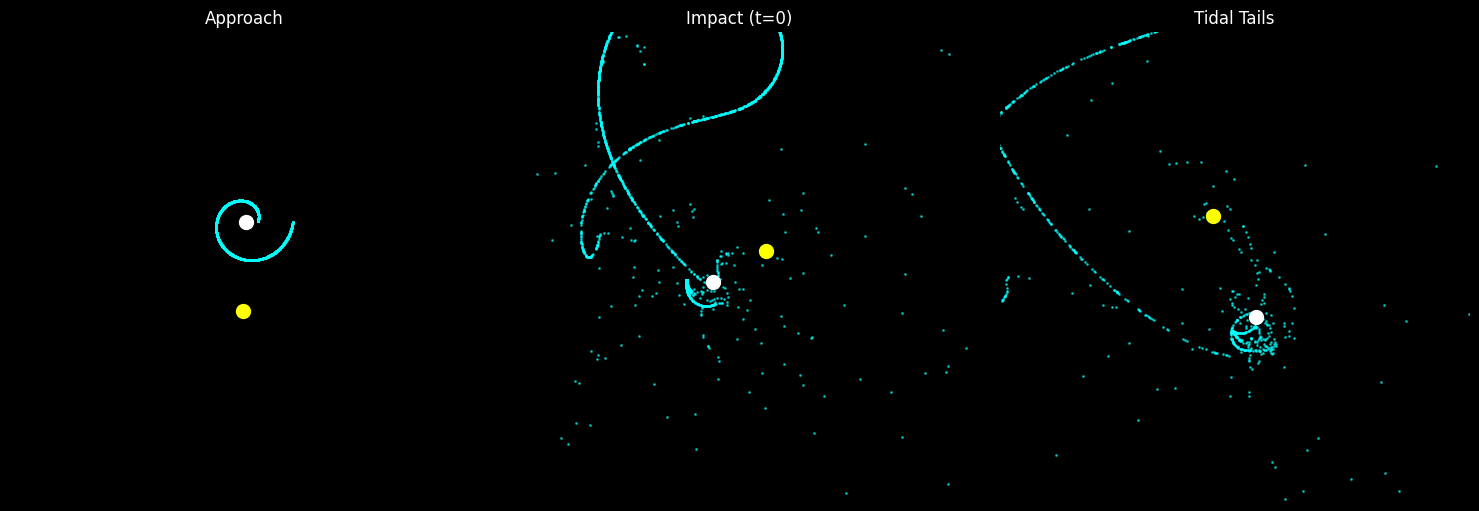

In [5]:
# スナップショットを描画する関数
def plot_snapshot(frame_idx, ax):
    p = history_pos[frame_idx]
    g1 = history_g1[frame_idx]
    g2 = history_g2[frame_idx]

    ax.scatter(p[:, 0], p[:, 1], s=1, c='cyan', alpha=0.6)
    ax.scatter(g1[0], g1[1], s=100, c='white', marker='o') # Galaxy 1
    ax.scatter(g2[0], g2[1], s=100, c='yellow', marker='o') # Galaxy 2

    ax.set_xlim(-40, 40)
    ax.set_ylim(-40, 40)
    ax.set_aspect('equal')
    ax.axis('off') # 軸を消して宇宙っぽく
    # 黒背景
    ax.set_facecolor('black')

# 3つの異なる時刻を表示
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_facecolor('black')

times_to_show = [0, len(history_pos)//2, len(history_pos)-1]
titles = ["Approach", "Impact (t=0)", "Tidal Tails"]

for ax, idx, title in zip(axes, times_to_show, titles):
    plot_snapshot(idx, ax)
    ax.set_title(title, color='white')

plt.tight_layout()
plt.show()

結論

右端の図を見てください。銀河の反対側に長く伸びる「尾（Tidal Tail）」と、銀河同士をつなぐ「橋（Bridge）」が形成されています。 JAXを使えば、この歴史的シミュレーションを数秒で再現できます。ぜひ上部の「Launch on Colab」ボタンを押して、eccentricity（離心率）や質量比を変えて遊んでみてください。